<a href="https://colab.research.google.com/github/divyaseri/divya_INFO5731_Fall2020/blob/master/In_class_exercise_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 10/21/2020)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [2]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 3.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=bc16d3df148167a115015ce467ea5c811b15e541bad24ce3ac48810f217ac786
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [17]:
!pip install spacy

In [33]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.2MB 1.4MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [16]:
import nltk; 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [50]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim # Gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [51]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [52]:
import pandas as pd
df = pd.read_csv("/content/Titles_data.csv")
df.head(10)

,Titles
0,Principles of data mining
1,Privacy-preserving data mining
2,Data mining: concepts and techniques
3,Data preparation for data mining
4,Untangling text data mining
5,Data mining applications in healthcare
6,Relational data mining
7,"Data warehousing, data mining, and OLAP"
8,Data mining with big data
9,Discovering knowledge in data: an introduction...


In [53]:
df["Titles"]=df["Titles"].str.lower()
data = df["Titles"].values.tolist() 
data = [re.sub(" $","",sent) for sent in data]
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]
print(data[:10])

['principles of data mining', 'privacy-preserving data mining', 'data mining: concepts and techniques', 'data preparation for data mining', 'untangling text data mining', 'data mining applications in healthcare', 'relational data mining', 'data warehousing, data mining, and olap', 'data mining with big data', 'discovering knowledge in data: an introduction to data mining']


In [54]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:10])

[['principles', 'of', 'data', 'mining'], ['privacy', 'preserving', 'data', 'mining'], ['data', 'mining', 'concepts', 'and', 'techniques'], ['data', 'preparation', 'for', 'data', 'mining'], ['untangling', 'text', 'data', 'mining'], ['data', 'mining', 'applications', 'in', 'healthcare'], ['relational', 'data', 'mining'], ['data', 'warehousing', 'data', 'mining', 'and', 'olap'], ['data', 'mining', 'with', 'big', 'data'], ['discovering', 'knowledge', 'in', 'data', 'an', 'introduction', 'to', 'data', 'mining']]


In [25]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['principles', 'of', 'data', 'mining']


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [26]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [27]:
# Remove Stop Words and form Bigrams
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Lemmatization keeping only NOUN,ADJ,VERB,ADV
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['datum', 'mining']]


In [28]:
# Create Dictionary, corpus, tdf and view
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [29]:
res = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:]]

In [30]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=10,random_state=100,update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)

In [31]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.101*"datum" + 0.086*"mining" + 0.072*"spatial" + 0.072*"clustering" + '
  '0.072*"method" + 0.038*"collaboration" + 0.038*"learn" + '
  '0.038*"communication" + 0.003*"ective" + 0.003*"discovery"'),
 (1,
  '0.141*"datum" + 0.113*"mining" + 0.029*"visual" + 0.029*"tool" + '
  '0.029*"text" + 0.015*"survey" + 0.015*"framework" + 0.015*"software" + '
  '0.015*"practical" + 0.015*"cluster"'),
 (2,
  '0.190*"datum" + 0.157*"mining" + 0.036*"technique" + 0.024*"mine" + '
  '0.024*"detection" + 0.024*"privacy" + 0.024*"approach" + 0.016*"concept" + '
  '0.013*"educational" + 0.013*"method"'),
 (3,
  '0.214*"datum" + 0.182*"mining" + 0.068*"model" + 0.035*"method" + '
  '0.035*"algorithm" + 0.035*"preparation" + 0.035*"education" + '
  '0.030*"concept" + 0.018*"cleaning" + 0.018*"personalization"'),
 (4,
  '0.137*"mining" + 0.062*"datum" + 0.062*"information" + 0.035*"network" + '
  '0.022*"ste" + 0.022*"statistical" + 0.022*"grid" + 0.022*"spatial" + '
  '0.022*"predictive" + 0.022*

In [32]:
#perplexity and coherence
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.136775813732051

Coherence Score:  0.5180116221930122


In [34]:
import os       #importing os to set variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)


In [35]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2020-10-23 03:42:43--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  9.05MB/s    in 1.7s    

2020-10-23 03:42:45 (9.05 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [36]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [37]:
pprint(ldamallet.show_topics(formatted=False))
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('mining', 0.375),
   ('discovery', 0.175),
   ('overview', 0.075),
   ('spatial', 0.075),
   ('unify', 0.025),
   ('primer', 0.025),
   ('dimensional', 0.025),
   ('cluster', 0.025),
   ('feature', 0.025),
   ('java', 0.025)]),
 (1,
  [('mine', 0.1935483870967742),
   ('statistical', 0.0967741935483871),
   ('method', 0.0967741935483871),
   ('network', 0.06451612903225806),
   ('feature', 0.03225806451612903),
   ('grid', 0.03225806451612903),
   ('framework', 0.03225806451612903),
   ('uniqueness', 0.03225806451612903),
   ('cleaning', 0.03225806451612903),
   ('fundamental', 0.03225806451612903)]),
 (2,
  [('datum', 0.32558139534883723),
   ('model', 0.09302325581395349),
   ('algorithm', 0.06976744186046512),
   ('learning', 0.06976744186046512),
   ('measure', 0.023255813953488372),
   ('guide', 0.023255813953488372),
   ('predictive', 0.023255813953488372),
   ('ste', 0.023255813953488372),
   ('advanced', 0.023255813953488372),
   ('navigation', 0.023255813953488372)]),

In [38]:
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [40]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [43]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)

In [44]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6778
Num Topics = 8  has Coherence Value of 0.7696
Num Topics = 14  has Coherence Value of 0.7561
Num Topics = 20  has Coherence Value of 0.7356
Num Topics = 26  has Coherence Value of 0.7099
Num Topics = 32  has Coherence Value of 0.7086
Num Topics = 38  has Coherence Value of 0.7022


In [45]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(13,
  '0.125*"framework" + 0.125*"advanced" + 0.125*"data" + 0.125*"intrusion" + '
  '0.125*"implementation" + 0.125*"classifier" + 0.125*"perspective" + '
  '0.125*"business" + 0.000*"user" + 0.000*"scalable"'),
 (28,
  '0.500*"knowledge" + 0.125*"text" + 0.125*"big" + 0.125*"selection" + '
  '0.125*"dimensional" + 0.000*"student" + 0.000*"performance" + '
  '0.000*"network" + 0.000*"sale" + 0.000*"educational"'),
 (29,
  '0.182*"education" + 0.182*"database" + 0.091*"software" + 0.091*"unify" + '
  '0.091*"management" + 0.091*"mine" + 0.091*"framework" + 0.091*"ste" + '
  '0.091*"customer" + 0.000*"navigation"'),
 (20,
  '0.333*"discovery" + 0.333*"survey" + 0.111*"marketing" + 0.111*"text" + '
  '0.111*"cluster" + 0.000*"navigation" + 0.000*"complex" + 0.000*"student" + '
  '0.000*"network" + 0.000*"fundamental"'),
 (17,
  '0.278*"mine" + 0.111*"concept" + 0.111*"relationship" + 0.111*"customer" + '
  '0.056*"java" + 0.056*"optimization" + 0.056*"review" + 0.056*"student" + '
  '0

## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

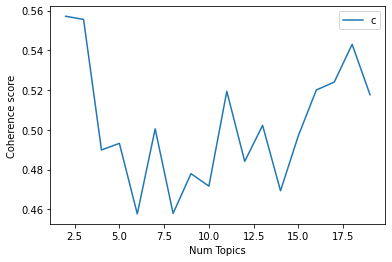

In [47]:

from gensim.models import LsiModel
def compute_lsa_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LsiModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

lsa_model_list, lsa_coherence_values = compute_lsa_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=1)


# Graph of Coherence Score against Number of Topics 
start=2; limit=20; step=1;
x = range(start, limit, step)
plt.plot(x, lsa_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [49]:
lsamodel = LsiModel(corpus=corpus, id2word=id2word, num_topics=2)

# EXAMINING THE RESULTS

from pprint import pprint
print('The topics using LSA Model are:')
pprint(lsamodel.print_topics())

# Compute Coherence Score
coherence_model_lsa = CoherenceModel(model=lsamodel, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('Coherence Score:', coherence_lsa)

The topics using LSA Model are:
[(0,
  '0.737*"mining" + 0.644*"datum" + 0.076*"technique" + 0.053*"method" + '
  '0.038*"algorithm" + 0.034*"discovery" + 0.034*"data" + 0.033*"customer" + '
  '0.033*"relationship" + 0.033*"management"'),
 (1,
  '-0.691*"datum" + 0.599*"mining" + 0.203*"discovery" + -0.152*"mine" + '
  '0.136*"data" + 0.074*"knowledge" + 0.068*"information" + '
  '-0.064*"preparation" + -0.060*"big" + 0.057*"privacy"')]
Coherence Score: 0.5526704897066645


## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
# Write your answer here (no code needed for this question)